In [12]:
!pip install -q langchain-community langchain-huggingface unstructured faiss-cpu langgraph

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%cd /content/drive/MyDrive/youtube/RAG/RetroBot

/content/drive/MyDrive/youtube/RAG/RetroBot


In [6]:
from google.colab import userdata
HUGGINGFACEHUB_API_TOKEN = userdata.get('HF_TOKEN')

In [7]:
from langchain_community.document_loaders import UnstructuredExcelLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.faiss import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFaceEmbeddings
from langchain.schema.output_parser import StrOutputParser

from typing import List, Dict, Any
from typing_extensions import TypedDict
from IPython.display import display, Image
import re
import json
import datetime

from langgraph.graph import StateGraph, END

In [9]:
file = "dim sum montijo.xlsx"
loader = UnstructuredExcelLoader(file, mode="elements")
data = loader.load()

In [10]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Create a vector store (FAISS) from the documents using the embeddings
db = FAISS.from_documents(data, hf)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
def get_model():
  llm = HuggingFaceEndpoint(
      repo_id="google/gemma-2-2b-it",
      task="text-generation",
      max_new_tokens=512,
      do_sample=False,
      repetition_penalty=1.03,
  )

  model = ChatHuggingFace(llm=llm)

  return model

In [15]:
# # Define a TypedDict to store the agent's state
class AgentState(TypedDict):
    start: bool             # Indicates if the conversation has started
    conversation: int       # Keeps track of conversation turns
    question: str           # Customer's question
    answer: str             # Agent's answer
    topic: bool             # Decision on whether the question is appropriate
    documents: list         # Relevant documents retrieved
    recursion_limit: int    # To avoid endless loops
    memory: list            # Conversation history
    entities: Dict          # Extracted entities from customer query
    recommended_items: List # Items recommended to the customer
    order: List             # Current customer order
    order_confirmed: bool   # Whether order is confirmed
    feedback: str           # Customer feedback

In [16]:
def greetings(state):
    # Greet the customer
    print("Hello! Welcome to our dim sum restaurant. I will be your waiter. How can I help you today?")

    # Capture user input
    user_input = input()

    # Update the state with the customer's question and initialize conversation variables
    state['question'] = user_input
    state['conversation'] = 1
    state['memory'] = [user_input]
    state['order'] = []
    state['recommended_items'] = []
    state['order_confirmed'] = False
    state['entities'] = {}

    return state

In [51]:
def check_question(state):
    # Get the customer's question from the state
    question = state['question']

    # Define the system prompt to evaluate the question's appropriateness
    system_prompt = """
    You are a grader evaluating the appropriateness of a customer's question to a waiter or waitress in a restaurant.
    Assess if the question is suitable to ask the restaurant staff and if the customer shows interest in continuing the conversation.
    Respond with "True" if the question is appropriate for the staff or indicates the customer is asking a question or giving you information.
    Otherwise respond with "False".
    Provide only "True" or "False" in your response.
    """


    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "User question: {question}"),
    ])

    # Format the prompt with the customer's question
    prompt = TEMPLATE.format(question=question)

    model = get_model()
    # Invoke the model with the prompt
    response_text = model.invoke(prompt)
    print(response_text)
    # Update the state with the model's decision
    state['topic'] = response_text.content.strip()
    print(state['topic'])
    return state

In [ ]:
# Function to check if the LLM model decides if the question is on topic on top
def topic_router(state):
  topic = state['topic']
  if topic == "True":
    return "on_topic"
    
  else:
    return "off_topic"

In [23]:
def off_topic_response(state):
    # Check if it's the first conversation turn
    if state['conversation'] <= 1:
        state['answer'] = "\nI apologize, I can't answer that question. I can only answer questions about restaurant."
        print(state['answer'])
    else:
        state['answer'] = "\nHappy to help."
        print(state['answer'])

In [29]:
def extract_entities(state):
    """Extract key entities from the customer's question"""
    question = state['question']
    memory = state['memory']

    system_prompt = """
    You are an entity extraction system for a restaurant.
    Extract the following entities from the customer's message:
    - food_items: List of food items mentioned
    - dietary_preferences: Any dietary preferences mentioned (vegetarian, vegan, gluten-free, etc.)
    - quantity: Any quantities mentioned for food items
    - special_requests: Any special requests for food preparation

    Format your response as a valid JSON object with these keys.
    If an entity type is not found, return an empty list or appropriate default value.
    """

    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Conversation history: {memory}\nCurrent customer message: {question}"),
    ])

    prompt = TEMPLATE.format(memory=memory, question=question)
    model = get_model()
    response_text = model.invoke(prompt)

    try:
        entities = json.loads(response_text.content.strip())
        state['entities'] = entities

        # Detect potential order items
        if 'food_items' in entities and entities['food_items']:
            for item in entities['food_items']:
                if item not in [order_item['item'] for order_item in state['order']]:
                    quantity = 1
                    if 'quantity' in entities and item in entities.get('quantity', {}):
                        quantity = entities['quantity'][item]

                    state['order'].append({
                        'item': item,
                        'quantity': quantity,
                        'confirmed': False
                    })
    except:
        # If JSON parsing fails, initialize with empty structure
        state['entities'] = {
            'food_items': [],
            'dietary_preferences': [],
            'quantity': {},
            'special_requests': []
        }

    return state


In [30]:
def intent_classifier(state):
    """Classify customer intent to route to specific functions"""
    question = state['question'].lower()
    memory = state['memory']

    system_prompt = """
    Classify the primary intent of the customer's message into exactly one of these categories:
    1. order - Customer wants to place or modify an order
    2. menu_inquiry - Customer is asking about menu items, ingredients, or recommendations
    3. payment - Customer wants to pay the bill
    5. greeting - Customer is just greeting or making small talk
    6. feedback - Customer is providing feedback
    7. confirmation - Customer is confirming or acknowledging something
    8. other - None of the above categories apply

    Provide only the category name (e.g., "order") without explanation.
    """

    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Conversation history: {memory}\nCustomer message: {question}"),
    ])

    prompt = TEMPLATE.format(memory=memory, question=question)
    model = get_model()
    response_text = model.invoke(prompt)

    intent = response_text.content.strip().lower()
    print(intent)
    # Map intents to routing decisions
    intent_routes = {
        "order": "handle_order",
        "menu_inquiry": "retrieve_docs",
        "payment": "handle_payment",
        "greeting": "handle_greeting",
        "feedback": "handle_feedback",
        "other": "retrieve_docs"  # Default to RAG for unclear intents
    }

    return intent_routes.get(intent, "retrieve_docs")


In [32]:
def handle_order(state):
    """Process customer orders"""
    question = state['question']
    current_order = state['order']

    system_prompt = """
    You are an order processing system for a dim sum restaurant.
    Based on the customer's message and current order, confirm their order items.
    For each item, confirm:
    1. The item name
    2. The quantity
    3. Any special preparation instructions

    Format your response as if you're a waiter confirming an order, being polite and professional.
    Be specific about what you're adding to their order.
    """

    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Customer message: {question}\nCurrent order: {current_order}"),
    ])

    prompt = TEMPLATE.format(question=question, current_order=current_order)
    model = get_model()
    response_text = model.invoke(prompt)

    # Update the order confirmation status
    for item in state['order']:
        item['confirmed'] = True

    state['answer'] = response_text.content.strip()
    print('\n')
    print(state['answer'])

    state['memory'].append(state['answer'])
    return state


In [36]:
def handle_payment(state):
    """Process payment requests"""
    question = state['question']
    order = state['order']

    # Calculate a mock total based on order items
    # In a real system, this would access pricing data
    mock_total = len(order) * 8.95 if order else 25.50

    system_prompt = f"""
    You are a waiter handling a payment request.
    The customer's bill total is ${mock_total:.2f}.
    Explain the payment options available (credit card, cash, mobile payment)
    and ask if they would like the bill brought to their table.
    Be polite, professional, and helpful in your response.
    """

    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Customer message: {question}\n"),
    ])

    prompt = TEMPLATE.format(question=question)
    model = get_model()
    response_text = model.invoke(prompt)

    state['answer'] = response_text.content.strip()
    print('\n')
    print(state['answer'])

    state['memory'].append(state['answer'])
    return state


In [37]:
def handle_greeting(state):
    """Handle casual greetings and small talk"""
    question = state['question']

    system_prompt = """
    You are a friendly waiter responding to a customer's greeting or small talk.
    Keep your response warm, personable but brief and professional.
    End with an open question about how you can help them with their dining experience today.
    """

    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Customer message: {question}"),
    ])

    prompt = TEMPLATE.format(question=question)
    model = get_model()
    response_text = model.invoke(prompt)

    state['answer'] = response_text.content.strip()
    print('\n')
    print(state['answer'])

    state['memory'].append(state['answer'])
    return state

def handle_feedback(state):
    """Process customer feedback"""
    question = state['question']

    system_prompt = """
    You are a waiter receiving customer feedback about their dining experience.
    Thank them sincerely for sharing their thoughts.
    Acknowledge specific points they made about their experience.
    If the feedback is positive, express appreciation.
    If the feedback is negative or contains suggestions, thank them for helping you improve.
    End with a brief, appropriate response that shows you value their input.
    """

    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Customer feedback: {question}\n"),
    ])

    prompt = TEMPLATE.format(question=question)
    model = get_model()
    response_text = model.invoke(prompt)

    # Store the feedback for future reference
    state['feedback'] = question

    state['answer'] = response_text.content.strip()
    print('\n')
    print(state['answer'])

    state['memory'].append(state['answer'])
    return state

In [53]:
def retrieve_docs(state):
    # Combine the conversation history into a single string
    memory = " ".join(state['memory'])

    # Retrieve the top 5 relevant documents based on similarity to the conversation history
    docs_faiss = db.similarity_search(memory, k=5)

    # Store the retrieved documents' content in the state
    state['documents'] = [doc.page_content for doc in docs_faiss]

    return state

In [54]:
def generate_recommendations(state):
    """Generate menu recommendations based on conversation context"""
    question = state['question']
    documents = state['documents']
    memory = state['memory']

    system_prompt = """
    You are a knowledgeable waiter at a dim sum restaurant.
    Based on the customer's query and conversation history, recommend 2-3 menu items that they might enjoy.
    Consider any dietary preferences or restrictions they've mentioned.
    For each recommendation, include:
    1. The name of the dish
    2. A brief description (1-2 sentences)
    3. Why you're recommending it based on their preferences

    Format each recommendation as a numbered list item.
    Base your recommendations on the actual menu items in the context provided.
    """

    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Menu context: {documents}\nConversation history: {memory}\nCustomer query: {question}"),
    ])

    prompt = TEMPLATE.format(documents=documents, memory=memory, question=question)
    model = get_model()
    response_text = model.invoke(prompt)

    # Extract recommended items
    recommendations = response_text.content.strip()

    # Update state with recommendations
    state['recommended_items'] = recommendations

    # Include recommendations in the response generation process
    state['documents'].append(f"Recommended items: {recommendations}")

    return state

In [55]:
def generate(state):
    # Initialize the language model
    model = get_model()

    # Extract necessary information from the state
    question = state['question']
    documents = state['documents']
    memory = state['memory']

    # Define the system prompt for the waiter
    system_prompt = """
    You are a waiter at a restaurant tasked with answering customer's questions about the menu.
    Answer the question in the manner of a waiter, avoiding being too verbose or too brief.
    Do not include "waiter" or refer to yourself explicitly in your answer.
    """

    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Context: {documents}\nConversation history so far: {memory}\nCustomer question: {question}"),
    ])

    # Format the prompt with the retrieved documents, conversation history, and customer's question
    prompt = TEMPLATE.format(documents=documents, memory=memory, question=question)

    # Invoke the model to generate an answer
    response_text = model.invoke(prompt)

    # Store the generated answer in the state
    state["answer"] = response_text.content.strip()

    return state

In [56]:
def improve_answer(state):
    # Extract necessary information from the state
    question = state['question']
    answer = state['answer']
    memory = state['memory']

    # Define the system prompt for refining the answer
    system = """
    As a waiter, review and refine the response to a customer's question. Your task is to:

    1. Ensure the answer is appropriate, friendly, and informative.
    2. Edit or remove parts of the answer as needed, without adding new information.
    3. Maintain a polite, professional, and attentive tone.
    4. Provide only the improved answer, without any introductory phrases or commentary.
    5. Conclude the response with an open-ended question to invite further inquiries or address additional needs.
    6. Consider the conversation history to be more informative and useful.
    7. Include line breaks (`\n`) at the end of each sentence or logical break.

    Deliver a refined response that enhances the customer's experience and reflects the restaurant's commitment to customer service.
    """

    # Create a prompt template for formatting
    TEMPLATE = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Customer question: {question}\nConversation history: {memory}\nWaiter's initial answer: {answer}"),
    ])

    # Initialize the language model
    model = get_model()

    # Format the prompt with the necessary information
    prompt = TEMPLATE.format(question=question, memory=memory, answer=answer)

    # Invoke the model to improve the answer
    response_text = model.invoke(prompt)

    # Update the state with the improved answer
    state['answer'] = response_text.content.strip()

    # Display the improved answer
    print('\n')
    print(state['answer'])

    # Append the improved answer to the conversation history
    state['memory'].append(state['answer'])

    return state


In [62]:
def further_question(state):
    # Prompt the customer for further input
    print('\n')
    user_input = input()

    # Update the state with the new question and increment the conversation turn
    state['question'] = user_input
    state['conversation'] += 1
    state['memory'].append(user_input)

    return state

In [64]:
# Initialize a StateGraph with the AgentState type
workflow = StateGraph(AgentState)

workflow.add_node("greetings", greetings)
workflow.add_node("check_question", check_question)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("extract_entities", extract_entities)
workflow.add_node("handle_order", handle_order)
workflow.add_node("handle_payment", handle_payment)
workflow.add_node("handle_greeting", handle_greeting)
workflow.add_node("handle_feedback", handle_feedback)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("generate_recommendations", generate_recommendations)
workflow.add_node("generate", generate)
workflow.add_node("improve_answer", improve_answer)
workflow.add_node("further_question", further_question)

# Add conditional edges based on the topic_router function's output
workflow.add_conditional_edges(
    "check_question",
    topic_router,
    {
        "on_topic": "extract_entities",
        "off_topic": "off_topic_response"
    }
)

workflow.add_conditional_edges(
    "extract_entities",
    intent_classifier,
    {
        "handle_order": "handle_order",
        "handle_payment": "handle_payment",
        "handle_greeting": "handle_greeting",
        "handle_feedback": "handle_feedback",
        "retrieve_docs": "retrieve_docs"
    }
)


# Set the entry point of the workflow to the greetings function
workflow.set_entry_point("greetings")

workflow.add_edge("greetings", "check_question")
workflow.add_edge("retrieve_docs", "generate_recommendations")
workflow.add_edge("generate_recommendations", "generate")
workflow.add_edge("generate", "improve_answer")
workflow.add_edge("improve_answer", "further_question")
workflow.add_edge("further_question", "check_question")
workflow.add_edge("handle_order", "further_question")
workflow.add_edge("handle_payment", "further_question")
workflow.add_edge("handle_greeting", "further_question")
workflow.add_edge("handle_feedback", "further_question")

workflow.add_edge("off_topic_response", END)

app = workflow.compile()

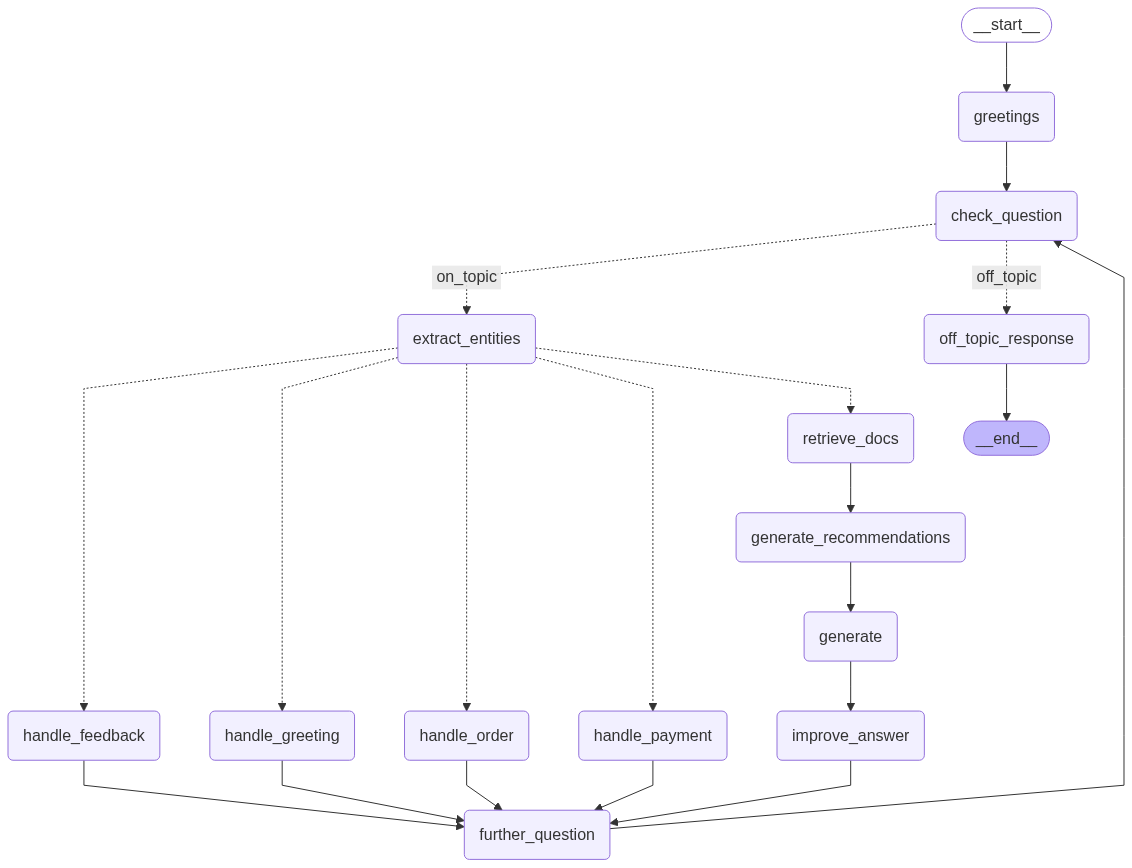

In [65]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [66]:
# Invoke the application with the initial state
result = app.invoke({"start": True}, {"recursion_limit": 50})

Hello! Welcome to our dim sum restaurant. I will be your waiter. How can I help you today?
I want 5 dim sim order and how can I pay?
content='True \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 132, 'total_tokens': 136}, 'model_name': 'google/gemma-2-2b-it', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run--26f76a1f-2a30-453c-bf16-fea5dff594ef-0' usage_metadata={'input_tokens': 132, 'output_tokens': 4, 'total_tokens': 136}
True
order


"Of course!  You'd like 5 dim sims, is that right?  

Here's what I have for you, ma'am:  5 dim sims. Please let me know if that's all you'd like to order. You can pay for it via cash or card at the end."


do you have any recommdation dim sim for me?
content='True \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 131, 'total_tokens': 135}, 'model_name': 'google/gemma-2-2b-it', 'system_fingerprint': None, 'finish_reason':